In [1]:
import sys
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD, RMSprop
from keras import layers, Sequential
from src.comparison_model import create_comparison_network
from src.feature_extractor import create_vgg19_feature_extractor
from src.utils  import *
from src.dataset import *


# Configs
sys.path.append('../../')
question_id = 2

In [2]:
vgg19_backbone = create_vgg19_feature_extractor()
vgg19_backbone.summary()

Model: "VGG19_Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                           

In [3]:
image_aug_layers = Sequential(
    [
        layers.RandomZoom(0.2),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.4)
    ]
)
comparison_network = create_comparison_network(img_size=(224, 224),
                                               feature_extractor=vgg19_backbone,
                                               image_augmentation_layers=image_aug_layers,
                                               num_conv_layers=3,
                                               conv_filters_list=[256, 256, 256],
                                               conv_kernel_size_list=[3, 3, 3],
                                               conv_activation_list=['relu', 'relu', 'relu'],
                                               conv_padding_list=['valid', 'same', 'same'])
comparison_network.summary()

Model: "Comparison_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image1_Input (InputLayer)      [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Image2_Input (InputLayer)      [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Preprocessing_Layers (Sequenti  (None, 224, 224, 3)  0          ['Image1_Input[0][0]',           
 al)                                                              'Image2_Input[0

In [4]:
images_dir = '../../data/Mapillary_data/Sample_web_green/' 
duel_results_path = f'../../data/duel_results/duels_question_{question_id}.csv'
img_size = 224  # 224 for VGG19
shuffle_seed = 1  # Seed for reproducibility

(x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_dataset(img_size,duel_results_path, images_dir, model_type='comparison', shuffle=True, shuffle_seed=shuffle_seed)

Number of duels before removing the duplicated duels: 4468
Number of duels after removing the duplicated duels: 4395


Processing Duels: 100%|██████████| 4395/4395 [00:32<00:00, 136.65it/s]


Dataset shuffled. Random seed:  1
Dataset split into train, validation and test sets. Split ratio:  [0.6, 0.2]


In [5]:
comparison_network.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history = comparison_network.fit(x_train, y_train,
                                      batch_size=32,
                                      epochs=50,
                                      validation_data=(x_val, y_val),
                                      callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
best_val_acc = max(history.history['val_accuracy'])
print(f'Best validation accuracy: {best_val_acc}')

Epoch 1/50
83/83 [==============================] - 36s 357ms/step - loss: 0.7092 - accuracy: 0.5658 - val_loss: 0.5975 - val_accuracy: 0.6780
Epoch 2/50
83/83 [==============================] - 28s 340ms/step - loss: 0.6007 - accuracy: 0.6784 - val_loss: 0.5628 - val_accuracy: 0.6962
Epoch 3/50
83/83 [==============================] - 28s 342ms/step - loss: 0.5673 - accuracy: 0.7061 - val_loss: 0.5493 - val_accuracy: 0.7008
Epoch 4/50
83/83 [==============================] - 28s 340ms/step - loss: 0.5602 - accuracy: 0.7182 - val_loss: 0.5327 - val_accuracy: 0.7349
Epoch 5/50
83/83 [==============================] - 28s 340ms/step - loss: 0.5373 - accuracy: 0.7330 - val_loss: 0.5281 - val_accuracy: 0.7463
Epoch 6/50
83/83 [==============================] - 28s 341ms/step - loss: 0.5276 - accuracy: 0.7315 - val_loss: 0.5211 - val_accuracy: 0.7281
Epoch 7/50
83/83 [==============================] - 28s 340ms/step - loss: 0.5151 - accuracy: 0.7543 - val_loss: 0.5498 - val_accuracy: 0.7440

Model history saved to csv!
Model architecture saved!
Model weights saved!
Model saved to keras!
Figure Training and ValidationLoss saved!


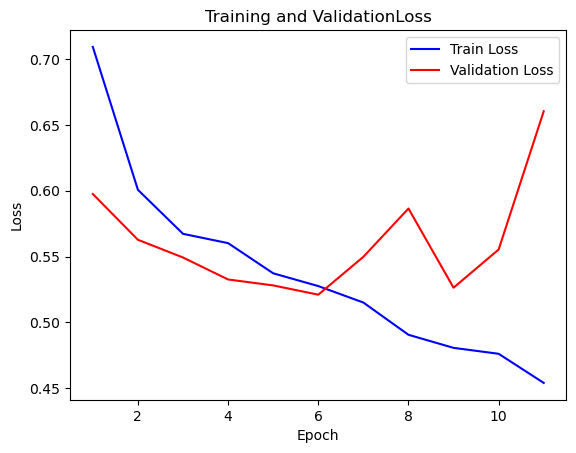

Figure Training and ValidationAccuracy saved!


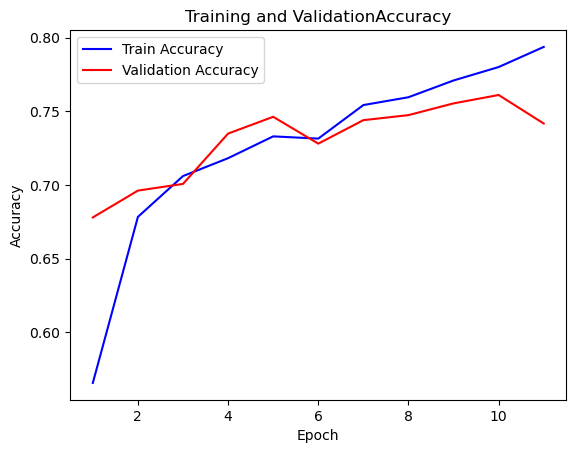

In [6]:
project_save_dir = f'../../results/comparison_models_from_scratch/q{question_id}_model_training/baseline_models/'
results_save_dir = os.path.join(project_save_dir, 'Comparison_VGG19_BestValAcc{:.4f}_Q{}_Dataset_rs{}'.format(best_val_acc, question_id, shuffle_seed))

safe_save_training_results(model=comparison_network, 
                           history=history, 
                           save_dir=results_save_dir)

plot_model_metrics(history, ['loss','accuracy'], save_dir=results_save_dir)